In [14]:
# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

# Add project root to sys.path
import sys
import os
sys.path.append(os.path.abspath('..'))

# Import from base_script.py (which is in the root folder)
from base_script import *

# Import custom functions from your utils package
from utils.models import VAE, CVAE

from utils.train_utils import (
    train_vae,
    loss_function,
    get_latent_mu,
    get_latent_mu_cvae,
    compute_condition_distances
)

from utils.data_utils import (
    load_all_fc_data,
    preprocess_for_torch
)

from utils.utils_plotting import (
    plot_vae_losses,
    plot_latent_embedding_by_condition_and_subject,
    plot_subject_distance_comparison
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sub_cond_path = '/Users/liuq13/NODEAP_scripts/data_input/SubConds.xlsx'
base_nifti_folder = '/Volumes/X9Pro/NODEAP/FuncConn_AAL'
condition_map = {'N': 0, 'S': 1, 'C': 2}

In [7]:
# Load and preprocess
use_roi = 0
all_corr_data, all_tms_type, all_subject_id, all_stimloc, all_session = load_all_fc_data(sub_cond_path, 
                                                               base_nifti_folder, 
                                                               mat_filename='conn_matrix_w_sphere.mat',
                                                               key_name='correlation_matrix',row_idx=use_roi)
# One-hot encode subject ID as condition
subject_arr = np.array(all_subject_id).reshape(-1, 1)
subject_encoder = OneHotEncoder(sparse_output=False, drop=None)
subject_ohe = subject_encoder.fit_transform(subject_arr)  # shape: [n_samples, n_subjects]

# Convert to torch tensors
X_tensor = preprocess_for_torch(all_corr_data)  
subject_cond_tensor = torch.tensor(subject_ohe, dtype=torch.float32)
dataset = TensorDataset(X_tensor, subject_cond_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_30/S3D2/conn_matrix_w_sphere.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_44/S1D1/conn_matrix_w_sphere.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_83/S3D1/conn_matrix_w_sphere.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_87/D0/conn_matrix_w_sphere.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_88/D0/conn_matrix_w_sphere.mat
Columns with NaN: 14 / 116
Tensor shape after preprocessing: torch.Size([331, 102])


In [8]:
X_tensor.shape

torch.Size([331, 102])

In [9]:
subject_cond_tensor.shape

torch.Size([331, 48])

In [10]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
cond_dim = subject_cond_tensor.shape[1]
latent_dim = 10
hidden_dim = 64 
NUM_EPOCH = 500
LR = 3e-4
model = CVAE(input_dim=input_dim, cond_dim=cond_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=DEVICE, epochs=NUM_EPOCH)


===== Epoch 1 =====


Epoch 1/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 167.16it/s]


Epoch 1, Loss: 103.9891, Recon: 103.7074, KL: 0.2817

===== Epoch 2 =====


Epoch 2/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 799.07it/s]


Epoch 2, Loss: 103.5093, Recon: 103.2608, KL: 0.2485

===== Epoch 3 =====


Epoch 3/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1111.88it/s]


Epoch 3, Loss: 103.0319, Recon: 102.7758, KL: 0.2562

===== Epoch 4 =====


Epoch 4/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1418.26it/s]


Epoch 4, Loss: 102.7731, Recon: 102.4849, KL: 0.2882

===== Epoch 5 =====


Epoch 5/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1341.08it/s]


Epoch 5, Loss: 102.5260, Recon: 102.1745, KL: 0.3516

===== Epoch 6 =====


Epoch 6/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1419.92it/s]


Epoch 6, Loss: 102.2092, Recon: 101.7573, KL: 0.4520

===== Epoch 7 =====


Epoch 7/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1226.60it/s]


Epoch 7, Loss: 101.5498, Recon: 100.9511, KL: 0.5987

===== Epoch 8 =====


Epoch 8/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1121.99it/s]


Epoch 8, Loss: 101.0012, Recon: 100.1482, KL: 0.8530

===== Epoch 9 =====


Epoch 9/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1053.22it/s]


Epoch 9, Loss: 99.6722, Recon: 98.3754, KL: 1.2968

===== Epoch 10 =====


Epoch 10/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1009.44it/s]


Epoch 10, Loss: 98.1426, Recon: 96.1206, KL: 2.0220

===== Epoch 11 =====


Epoch 11/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1076.64it/s]


Epoch 11, Loss: 95.2446, Recon: 92.0501, KL: 3.1945

===== Epoch 12 =====


Epoch 12/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1221.53it/s]


Epoch 12, Loss: 91.8967, Recon: 87.1889, KL: 4.7078

===== Epoch 13 =====


Epoch 13/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1179.14it/s]


Epoch 13, Loss: 88.4683, Recon: 82.3107, KL: 6.1576

===== Epoch 14 =====


Epoch 14/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1267.44it/s]


Epoch 14, Loss: 84.6851, Recon: 77.8324, KL: 6.8527

===== Epoch 15 =====


Epoch 15/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1366.95it/s]


Epoch 15, Loss: 81.8120, Recon: 74.9640, KL: 6.8480

===== Epoch 16 =====


Epoch 16/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1407.91it/s]


Epoch 16, Loss: 79.3319, Recon: 72.2429, KL: 7.0890

===== Epoch 17 =====


Epoch 17/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1334.95it/s]


Epoch 17, Loss: 76.3385, Recon: 68.5050, KL: 7.8335

===== Epoch 18 =====


Epoch 18/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1283.66it/s]


Epoch 18, Loss: 73.8393, Recon: 65.4944, KL: 8.3448

===== Epoch 19 =====


Epoch 19/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1438.47it/s]


Epoch 19, Loss: 71.2865, Recon: 62.6188, KL: 8.6676

===== Epoch 20 =====


Epoch 20/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1322.59it/s]


Epoch 20, Loss: 70.1843, Recon: 61.2961, KL: 8.8882

===== Epoch 21 =====


Epoch 21/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1175.56it/s]


Epoch 21, Loss: 67.6869, Recon: 58.5184, KL: 9.1685

===== Epoch 22 =====


Epoch 22/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1364.97it/s]


Epoch 22, Loss: 66.2554, Recon: 57.6178, KL: 8.6377

===== Epoch 23 =====


Epoch 23/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1190.86it/s]


Epoch 23, Loss: 64.9364, Recon: 56.3325, KL: 8.6039

===== Epoch 24 =====


Epoch 24/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 841.17it/s]


Epoch 24, Loss: 63.8752, Recon: 55.3132, KL: 8.5621

===== Epoch 25 =====


Epoch 25/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 244.90it/s]


Epoch 25, Loss: 62.4198, Recon: 53.6086, KL: 8.8112

===== Epoch 26 =====


Epoch 26/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 554.00it/s]


Epoch 26, Loss: 61.9120, Recon: 53.0278, KL: 8.8842

===== Epoch 27 =====


Epoch 27/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1214.30it/s]


Epoch 27, Loss: 60.7984, Recon: 51.9513, KL: 8.8471

===== Epoch 28 =====


Epoch 28/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 386.69it/s]


Epoch 28, Loss: 60.0906, Recon: 51.2105, KL: 8.8801

===== Epoch 29 =====


Epoch 29/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 305.98it/s]


Epoch 29, Loss: 59.8126, Recon: 50.8819, KL: 8.9307

===== Epoch 30 =====


Epoch 30/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1408.82it/s]


Epoch 30, Loss: 58.7585, Recon: 49.9079, KL: 8.8506

===== Epoch 31 =====


Epoch 31/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1339.37it/s]


Epoch 31, Loss: 58.7155, Recon: 49.9613, KL: 8.7542

===== Epoch 32 =====


Epoch 32/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1358.38it/s]


Epoch 32, Loss: 58.3467, Recon: 49.5698, KL: 8.7769

===== Epoch 33 =====


Epoch 33/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 264.43it/s]


Epoch 33, Loss: 57.5810, Recon: 48.8861, KL: 8.6949

===== Epoch 34 =====


Epoch 34/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1356.22it/s]


Epoch 34, Loss: 57.2796, Recon: 48.8293, KL: 8.4504

===== Epoch 35 =====


Epoch 35/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 522.32it/s]


Epoch 35, Loss: 57.2076, Recon: 48.8860, KL: 8.3216

===== Epoch 36 =====


Epoch 36/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 681.16it/s]


Epoch 36, Loss: 56.7934, Recon: 48.2860, KL: 8.5074

===== Epoch 37 =====


Epoch 37/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 359.70it/s]


Epoch 37, Loss: 56.3527, Recon: 47.8689, KL: 8.4838

===== Epoch 38 =====


Epoch 38/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1183.16it/s]


Epoch 38, Loss: 56.3936, Recon: 48.0155, KL: 8.3781

===== Epoch 39 =====


Epoch 39/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1248.30it/s]


Epoch 39, Loss: 55.8188, Recon: 47.3379, KL: 8.4810

===== Epoch 40 =====


Epoch 40/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1363.44it/s]


Epoch 40, Loss: 55.4683, Recon: 47.1855, KL: 8.2828

===== Epoch 41 =====


Epoch 41/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1497.63it/s]


Epoch 41, Loss: 55.5328, Recon: 47.2823, KL: 8.2505

===== Epoch 42 =====


Epoch 42/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1344.41it/s]


Epoch 42, Loss: 55.2253, Recon: 47.0178, KL: 8.2075

===== Epoch 43 =====


Epoch 43/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1359.06it/s]


Epoch 43, Loss: 54.6308, Recon: 46.4640, KL: 8.1668

===== Epoch 44 =====


Epoch 44/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1391.02it/s]


Epoch 44, Loss: 54.8080, Recon: 46.7068, KL: 8.1013

===== Epoch 45 =====


Epoch 45/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1378.63it/s]


Epoch 45, Loss: 54.2194, Recon: 45.9408, KL: 8.2786

===== Epoch 46 =====


Epoch 46/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1450.40it/s]


Epoch 46, Loss: 54.1852, Recon: 46.0732, KL: 8.1120

===== Epoch 47 =====


Epoch 47/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 467.37it/s]


Epoch 47, Loss: 53.5918, Recon: 45.3997, KL: 8.1921

===== Epoch 48 =====


Epoch 48/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1356.98it/s]


Epoch 48, Loss: 53.8418, Recon: 45.5460, KL: 8.2958

===== Epoch 49 =====


Epoch 49/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1408.77it/s]


Epoch 49, Loss: 53.1666, Recon: 44.8779, KL: 8.2887

===== Epoch 50 =====


Epoch 50/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1204.69it/s]


Epoch 50, Loss: 53.0918, Recon: 44.8574, KL: 8.2345

===== Epoch 51 =====


Epoch 51/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1286.38it/s]


Epoch 51, Loss: 52.8265, Recon: 44.5138, KL: 8.3127

===== Epoch 52 =====


Epoch 52/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1272.58it/s]


Epoch 52, Loss: 52.4047, Recon: 43.9126, KL: 8.4920

===== Epoch 53 =====


Epoch 53/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1405.60it/s]


Epoch 53, Loss: 52.2947, Recon: 43.8476, KL: 8.4471

===== Epoch 54 =====


Epoch 54/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1362.51it/s]


Epoch 54, Loss: 51.9815, Recon: 43.4975, KL: 8.4841

===== Epoch 55 =====


Epoch 55/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1413.35it/s]


Epoch 55, Loss: 51.9147, Recon: 43.3683, KL: 8.5464

===== Epoch 56 =====


Epoch 56/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1440.94it/s]


Epoch 56, Loss: 51.8776, Recon: 43.3944, KL: 8.4832

===== Epoch 57 =====


Epoch 57/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1392.41it/s]


Epoch 57, Loss: 51.4882, Recon: 42.7769, KL: 8.7112

===== Epoch 58 =====


Epoch 58/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1431.01it/s]


Epoch 58, Loss: 51.3331, Recon: 42.4339, KL: 8.8992

===== Epoch 59 =====


Epoch 59/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1436.54it/s]


Epoch 59, Loss: 51.2813, Recon: 42.4163, KL: 8.8650

===== Epoch 60 =====


Epoch 60/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 251.14it/s]


Epoch 60, Loss: 50.3483, Recon: 41.6221, KL: 8.7262

===== Epoch 61 =====


Epoch 61/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 175.46it/s]


Epoch 61, Loss: 50.3636, Recon: 41.7547, KL: 8.6088

===== Epoch 62 =====


Epoch 62/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1321.34it/s]


Epoch 62, Loss: 50.0114, Recon: 41.3461, KL: 8.6653

===== Epoch 63 =====


Epoch 63/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1310.76it/s]


Epoch 63, Loss: 50.1759, Recon: 41.5605, KL: 8.6154

===== Epoch 64 =====


Epoch 64/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1514.74it/s]


Epoch 64, Loss: 50.1256, Recon: 41.3581, KL: 8.7676

===== Epoch 65 =====


Epoch 65/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 348.24it/s]


Epoch 65, Loss: 49.6224, Recon: 40.8804, KL: 8.7419

===== Epoch 66 =====


Epoch 66/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1442.60it/s]


Epoch 66, Loss: 49.9195, Recon: 41.2773, KL: 8.6421

===== Epoch 67 =====


Epoch 67/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1431.55it/s]


Epoch 67, Loss: 49.7753, Recon: 40.9304, KL: 8.8449

===== Epoch 68 =====


Epoch 68/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1423.33it/s]


Epoch 68, Loss: 49.4517, Recon: 40.5297, KL: 8.9220

===== Epoch 69 =====


Epoch 69/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1538.07it/s]


Epoch 69, Loss: 49.5954, Recon: 40.7339, KL: 8.8615

===== Epoch 70 =====


Epoch 70/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1339.49it/s]


Epoch 70, Loss: 49.1540, Recon: 40.3465, KL: 8.8076

===== Epoch 71 =====


Epoch 71/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1224.81it/s]


Epoch 71, Loss: 48.6746, Recon: 39.8880, KL: 8.7866

===== Epoch 72 =====


Epoch 72/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1308.27it/s]


Epoch 72, Loss: 48.7504, Recon: 40.0049, KL: 8.7454

===== Epoch 73 =====


Epoch 73/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 575.43it/s]


Epoch 73, Loss: 48.7021, Recon: 40.0196, KL: 8.6825

===== Epoch 74 =====


Epoch 74/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1364.73it/s]


Epoch 74, Loss: 48.3305, Recon: 39.6423, KL: 8.6882

===== Epoch 75 =====


Epoch 75/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1451.13it/s]


Epoch 75, Loss: 48.3667, Recon: 39.6003, KL: 8.7664

===== Epoch 76 =====


Epoch 76/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1421.32it/s]


Epoch 76, Loss: 48.2378, Recon: 39.5173, KL: 8.7205

===== Epoch 77 =====


Epoch 77/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 151.65it/s]


Epoch 77, Loss: 48.1824, Recon: 39.4184, KL: 8.7640

===== Epoch 78 =====


Epoch 78/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1329.99it/s]


Epoch 78, Loss: 47.9376, Recon: 39.1478, KL: 8.7898

===== Epoch 79 =====


Epoch 79/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1448.72it/s]


Epoch 79, Loss: 47.3745, Recon: 38.5079, KL: 8.8666

===== Epoch 80 =====


Epoch 80/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1321.00it/s]


Epoch 80, Loss: 47.1576, Recon: 38.3237, KL: 8.8339

===== Epoch 81 =====


Epoch 81/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1380.70it/s]


Epoch 81, Loss: 47.6448, Recon: 38.9186, KL: 8.7263

===== Epoch 82 =====


Epoch 82/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1428.75it/s]


Epoch 82, Loss: 46.9502, Recon: 38.1850, KL: 8.7652

===== Epoch 83 =====


Epoch 83/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1470.98it/s]


Epoch 83, Loss: 47.2192, Recon: 38.5154, KL: 8.7038

===== Epoch 84 =====


Epoch 84/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1530.26it/s]


Epoch 84, Loss: 46.5299, Recon: 37.7717, KL: 8.7582

===== Epoch 85 =====


Epoch 85/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 408.28it/s]


Epoch 85, Loss: 46.6956, Recon: 37.9243, KL: 8.7713

===== Epoch 86 =====


Epoch 86/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1364.28it/s]


Epoch 86, Loss: 46.1279, Recon: 37.3453, KL: 8.7826

===== Epoch 87 =====


Epoch 87/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1237.76it/s]


Epoch 87, Loss: 46.4614, Recon: 37.7314, KL: 8.7300

===== Epoch 88 =====


Epoch 88/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1387.88it/s]


Epoch 88, Loss: 46.0406, Recon: 37.3442, KL: 8.6964

===== Epoch 89 =====


Epoch 89/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1346.56it/s]


Epoch 89, Loss: 45.8613, Recon: 37.0537, KL: 8.8076

===== Epoch 90 =====


Epoch 90/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1300.38it/s]


Epoch 90, Loss: 46.0990, Recon: 37.1909, KL: 8.9081

===== Epoch 91 =====


Epoch 91/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1401.12it/s]


Epoch 91, Loss: 45.5855, Recon: 36.5979, KL: 8.9876

===== Epoch 92 =====


Epoch 92/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1484.90it/s]


Epoch 92, Loss: 45.7142, Recon: 36.8298, KL: 8.8844

===== Epoch 93 =====


Epoch 93/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 657.03it/s]


Epoch 93, Loss: 45.4803, Recon: 36.5017, KL: 8.9785

===== Epoch 94 =====


Epoch 94/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1377.07it/s]


Epoch 94, Loss: 45.1409, Recon: 36.0360, KL: 9.1049

===== Epoch 95 =====


Epoch 95/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1227.25it/s]


Epoch 95, Loss: 45.0798, Recon: 35.9997, KL: 9.0800

===== Epoch 96 =====


Epoch 96/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1317.68it/s]


Epoch 96, Loss: 44.7058, Recon: 35.7570, KL: 8.9488

===== Epoch 97 =====


Epoch 97/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1491.91it/s]


Epoch 97, Loss: 44.4691, Recon: 35.5241, KL: 8.9450

===== Epoch 98 =====


Epoch 98/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1356.86it/s]


Epoch 98, Loss: 44.6154, Recon: 35.5588, KL: 9.0566

===== Epoch 99 =====


Epoch 99/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1361.06it/s]


Epoch 99, Loss: 44.2701, Recon: 35.3658, KL: 8.9043

===== Epoch 100 =====


Epoch 100/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1413.52it/s]


Epoch 100, Loss: 44.4053, Recon: 35.4040, KL: 9.0013

===== Epoch 101 =====


Epoch 101/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1438.06it/s]


Epoch 101, Loss: 44.4945, Recon: 35.4125, KL: 9.0820

===== Epoch 102 =====


Epoch 102/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1395.56it/s]


Epoch 102, Loss: 44.2550, Recon: 35.0676, KL: 9.1874

===== Epoch 103 =====


Epoch 103/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1515.13it/s]


Epoch 103, Loss: 44.1337, Recon: 34.8858, KL: 9.2479

===== Epoch 104 =====


Epoch 104/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1440.71it/s]


Epoch 104, Loss: 43.7500, Recon: 34.4872, KL: 9.2628

===== Epoch 105 =====


Epoch 105/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1482.13it/s]


Epoch 105, Loss: 43.3429, Recon: 34.1255, KL: 9.2174

===== Epoch 106 =====


Epoch 106/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1514.54it/s]


Epoch 106, Loss: 43.6183, Recon: 34.4418, KL: 9.1765

===== Epoch 107 =====


Epoch 107/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1442.42it/s]


Epoch 107, Loss: 43.0821, Recon: 34.0051, KL: 9.0770

===== Epoch 108 =====


Epoch 108/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1479.90it/s]


Epoch 108, Loss: 43.2240, Recon: 34.1588, KL: 9.0653

===== Epoch 109 =====


Epoch 109/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1335.15it/s]


Epoch 109, Loss: 43.2354, Recon: 34.1523, KL: 9.0831

===== Epoch 110 =====


Epoch 110/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1275.53it/s]


Epoch 110, Loss: 42.7923, Recon: 33.6630, KL: 9.1293

===== Epoch 111 =====


Epoch 111/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1410.28it/s]


Epoch 111, Loss: 42.7552, Recon: 33.6928, KL: 9.0625

===== Epoch 112 =====


Epoch 112/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 610.00it/s]


Epoch 112, Loss: 42.5195, Recon: 33.5496, KL: 8.9699

===== Epoch 113 =====


Epoch 113/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1187.03it/s]


Epoch 113, Loss: 42.4363, Recon: 33.5064, KL: 8.9299

===== Epoch 114 =====


Epoch 114/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1347.55it/s]


Epoch 114, Loss: 42.4414, Recon: 33.4509, KL: 8.9905

===== Epoch 115 =====


Epoch 115/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 420.29it/s]


Epoch 115, Loss: 42.0136, Recon: 32.9590, KL: 9.0546

===== Epoch 116 =====


Epoch 116/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1481.09it/s]


Epoch 116, Loss: 41.9238, Recon: 32.8393, KL: 9.0846

===== Epoch 117 =====


Epoch 117/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1417.17it/s]


Epoch 117, Loss: 42.2929, Recon: 33.2616, KL: 9.0314

===== Epoch 118 =====


Epoch 118/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1387.13it/s]


Epoch 118, Loss: 42.2250, Recon: 33.1522, KL: 9.0728

===== Epoch 119 =====


Epoch 119/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1437.52it/s]


Epoch 119, Loss: 42.0399, Recon: 32.8928, KL: 9.1471

===== Epoch 120 =====


Epoch 120/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1346.05it/s]


Epoch 120, Loss: 41.7788, Recon: 32.5572, KL: 9.2217

===== Epoch 121 =====


Epoch 121/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1233.98it/s]


Epoch 121, Loss: 41.6507, Recon: 32.4694, KL: 9.1812

===== Epoch 122 =====


Epoch 122/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1382.60it/s]


Epoch 122, Loss: 41.3746, Recon: 32.1551, KL: 9.2196

===== Epoch 123 =====


Epoch 123/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1475.69it/s]


Epoch 123, Loss: 41.3179, Recon: 32.0741, KL: 9.2439

===== Epoch 124 =====


Epoch 124/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 660.43it/s]


Epoch 124, Loss: 41.4115, Recon: 32.2954, KL: 9.1161

===== Epoch 125 =====


Epoch 125/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1362.91it/s]


Epoch 125, Loss: 40.7342, Recon: 31.5945, KL: 9.1396

===== Epoch 126 =====


Epoch 126/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.32it/s]


Epoch 126, Loss: 41.1999, Recon: 32.0890, KL: 9.1109

===== Epoch 127 =====


Epoch 127/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 283.35it/s]


Epoch 127, Loss: 41.1178, Recon: 32.0313, KL: 9.0866

===== Epoch 128 =====


Epoch 128/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1391.15it/s]


Epoch 128, Loss: 40.8911, Recon: 31.7656, KL: 9.1256

===== Epoch 129 =====


Epoch 129/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1352.68it/s]


Epoch 129, Loss: 40.6619, Recon: 31.4344, KL: 9.2275

===== Epoch 130 =====


Epoch 130/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1329.34it/s]


Epoch 130, Loss: 40.4081, Recon: 31.0914, KL: 9.3167

===== Epoch 131 =====


Epoch 131/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1273.28it/s]


Epoch 131, Loss: 40.4601, Recon: 31.2264, KL: 9.2337

===== Epoch 132 =====


Epoch 132/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1286.09it/s]


Epoch 132, Loss: 40.6351, Recon: 31.4269, KL: 9.2082

===== Epoch 133 =====


Epoch 133/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.67it/s]


Epoch 133, Loss: 40.1745, Recon: 30.8808, KL: 9.2937

===== Epoch 134 =====


Epoch 134/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1406.84it/s]


Epoch 134, Loss: 40.4018, Recon: 31.2009, KL: 9.2009

===== Epoch 135 =====


Epoch 135/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1508.35it/s]


Epoch 135, Loss: 40.0461, Recon: 30.8738, KL: 9.1724

===== Epoch 136 =====


Epoch 136/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1418.26it/s]


Epoch 136, Loss: 40.0045, Recon: 30.7339, KL: 9.2706

===== Epoch 137 =====


Epoch 137/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1335.96it/s]


Epoch 137, Loss: 39.9454, Recon: 30.5943, KL: 9.3511

===== Epoch 138 =====


Epoch 138/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1399.33it/s]


Epoch 138, Loss: 39.7477, Recon: 30.4476, KL: 9.3001

===== Epoch 139 =====


Epoch 139/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1370.52it/s]


Epoch 139, Loss: 39.8982, Recon: 30.5707, KL: 9.3274

===== Epoch 140 =====


Epoch 140/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1383.64it/s]


Epoch 140, Loss: 39.8135, Recon: 30.4940, KL: 9.3195

===== Epoch 141 =====


Epoch 141/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1443.55it/s]


Epoch 141, Loss: 39.1585, Recon: 29.8668, KL: 9.2916

===== Epoch 142 =====


Epoch 142/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1560.28it/s]


Epoch 142, Loss: 39.5372, Recon: 30.2841, KL: 9.2531

===== Epoch 143 =====


Epoch 143/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1282.98it/s]


Epoch 143, Loss: 39.4486, Recon: 30.2452, KL: 9.2034

===== Epoch 144 =====


Epoch 144/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1215.87it/s]


Epoch 144, Loss: 39.1104, Recon: 29.8601, KL: 9.2503

===== Epoch 145 =====


Epoch 145/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1351.85it/s]


Epoch 145, Loss: 39.1848, Recon: 29.8660, KL: 9.3188

===== Epoch 146 =====


Epoch 146/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1280.24it/s]


Epoch 146, Loss: 39.4474, Recon: 30.1542, KL: 9.2932

===== Epoch 147 =====


Epoch 147/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1365.78it/s]


Epoch 147, Loss: 38.9611, Recon: 29.6893, KL: 9.2718

===== Epoch 148 =====


Epoch 148/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1442.83it/s]


Epoch 148, Loss: 39.0159, Recon: 29.7675, KL: 9.2485

===== Epoch 149 =====


Epoch 149/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1461.62it/s]


Epoch 149, Loss: 38.4454, Recon: 29.1618, KL: 9.2836

===== Epoch 150 =====


Epoch 150/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1311.58it/s]


Epoch 150, Loss: 38.8770, Recon: 29.5984, KL: 9.2786

===== Epoch 151 =====


Epoch 151/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1340.62it/s]


Epoch 151, Loss: 38.6779, Recon: 29.3574, KL: 9.3205

===== Epoch 152 =====


Epoch 152/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1360.54it/s]


Epoch 152, Loss: 38.5005, Recon: 29.1118, KL: 9.3887

===== Epoch 153 =====


Epoch 153/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.83it/s]


Epoch 153, Loss: 38.6722, Recon: 29.3023, KL: 9.3699

===== Epoch 154 =====


Epoch 154/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1398.40it/s]


Epoch 154, Loss: 38.4887, Recon: 29.1384, KL: 9.3503

===== Epoch 155 =====


Epoch 155/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1284.91it/s]


Epoch 155, Loss: 38.1652, Recon: 28.8979, KL: 9.2673

===== Epoch 156 =====


Epoch 156/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1352.01it/s]


Epoch 156, Loss: 38.3611, Recon: 29.0387, KL: 9.3224

===== Epoch 157 =====


Epoch 157/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1300.52it/s]


Epoch 157, Loss: 38.5052, Recon: 29.0946, KL: 9.4106

===== Epoch 158 =====


Epoch 158/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1517.28it/s]


Epoch 158, Loss: 38.0398, Recon: 28.6392, KL: 9.4006

===== Epoch 159 =====


Epoch 159/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1353.99it/s]


Epoch 159, Loss: 37.8674, Recon: 28.5327, KL: 9.3347

===== Epoch 160 =====


Epoch 160/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1413.52it/s]


Epoch 160, Loss: 37.8193, Recon: 28.4409, KL: 9.3783

===== Epoch 161 =====


Epoch 161/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1368.49it/s]


Epoch 161, Loss: 38.0669, Recon: 28.6780, KL: 9.3890

===== Epoch 162 =====


Epoch 162/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1439.81it/s]


Epoch 162, Loss: 38.0182, Recon: 28.6267, KL: 9.3916

===== Epoch 163 =====


Epoch 163/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1344.56it/s]


Epoch 163, Loss: 37.6410, Recon: 28.1945, KL: 9.4465

===== Epoch 164 =====


Epoch 164/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1308.56it/s]


Epoch 164, Loss: 37.5635, Recon: 28.1552, KL: 9.4083

===== Epoch 165 =====


Epoch 165/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1261.07it/s]


Epoch 165, Loss: 37.4942, Recon: 28.1457, KL: 9.3484

===== Epoch 166 =====


Epoch 166/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1272.12it/s]


Epoch 166, Loss: 37.3828, Recon: 28.0160, KL: 9.3668

===== Epoch 167 =====


Epoch 167/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.86it/s]


Epoch 167, Loss: 37.1250, Recon: 27.7669, KL: 9.3581

===== Epoch 168 =====


Epoch 168/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1376.37it/s]


Epoch 168, Loss: 37.4586, Recon: 28.1021, KL: 9.3565

===== Epoch 169 =====


Epoch 169/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1420.44it/s]


Epoch 169, Loss: 37.1068, Recon: 27.7525, KL: 9.3543

===== Epoch 170 =====


Epoch 170/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1434.31it/s]


Epoch 170, Loss: 36.9885, Recon: 27.6004, KL: 9.3881

===== Epoch 171 =====


Epoch 171/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1477.15it/s]


Epoch 171, Loss: 37.3030, Recon: 27.8886, KL: 9.4144

===== Epoch 172 =====


Epoch 172/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1308.30it/s]


Epoch 172, Loss: 37.0682, Recon: 27.6869, KL: 9.3813

===== Epoch 173 =====


Epoch 173/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1450.40it/s]


Epoch 173, Loss: 36.8252, Recon: 27.4187, KL: 9.4066

===== Epoch 174 =====


Epoch 174/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1304.72it/s]


Epoch 174, Loss: 36.9980, Recon: 27.6323, KL: 9.3657

===== Epoch 175 =====


Epoch 175/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1391.48it/s]


Epoch 175, Loss: 36.8784, Recon: 27.5498, KL: 9.3286

===== Epoch 176 =====


Epoch 176/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1434.75it/s]


Epoch 176, Loss: 36.6788, Recon: 27.2615, KL: 9.4174

===== Epoch 177 =====


Epoch 177/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1480.04it/s]


Epoch 177, Loss: 36.6688, Recon: 27.2447, KL: 9.4241

===== Epoch 178 =====


Epoch 178/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1408.43it/s]


Epoch 178, Loss: 36.5846, Recon: 27.2245, KL: 9.3602

===== Epoch 179 =====


Epoch 179/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.38it/s]


Epoch 179, Loss: 36.6378, Recon: 27.2784, KL: 9.3594

===== Epoch 180 =====


Epoch 180/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 626.71it/s]


Epoch 180, Loss: 36.3732, Recon: 27.0009, KL: 9.3722

===== Epoch 181 =====


Epoch 181/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1410.58it/s]


Epoch 181, Loss: 36.6647, Recon: 27.3498, KL: 9.3148

===== Epoch 182 =====


Epoch 182/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1459.44it/s]


Epoch 182, Loss: 36.3512, Recon: 26.9916, KL: 9.3596

===== Epoch 183 =====


Epoch 183/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.58it/s]


Epoch 183, Loss: 36.2602, Recon: 26.9012, KL: 9.3589

===== Epoch 184 =====


Epoch 184/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1393.29it/s]


Epoch 184, Loss: 36.3505, Recon: 26.9725, KL: 9.3779

===== Epoch 185 =====


Epoch 185/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.45it/s]


Epoch 185, Loss: 36.4458, Recon: 27.0357, KL: 9.4102

===== Epoch 186 =====


Epoch 186/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1534.84it/s]


Epoch 186, Loss: 36.3035, Recon: 26.8403, KL: 9.4633

===== Epoch 187 =====


Epoch 187/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1401.63it/s]


Epoch 187, Loss: 36.0646, Recon: 26.5757, KL: 9.4889

===== Epoch 188 =====


Epoch 188/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1320.70it/s]


Epoch 188, Loss: 35.9952, Recon: 26.5820, KL: 9.4132

===== Epoch 189 =====


Epoch 189/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1458.66it/s]


Epoch 189, Loss: 36.0019, Recon: 26.5996, KL: 9.4023

===== Epoch 190 =====


Epoch 190/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1371.22it/s]


Epoch 190, Loss: 36.0015, Recon: 26.5312, KL: 9.4703

===== Epoch 191 =====


Epoch 191/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1425.66it/s]


Epoch 191, Loss: 35.6563, Recon: 26.1731, KL: 9.4832

===== Epoch 192 =====


Epoch 192/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1460.64it/s]


Epoch 192, Loss: 35.9830, Recon: 26.5578, KL: 9.4252

===== Epoch 193 =====


Epoch 193/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1456.77it/s]


Epoch 193, Loss: 35.6630, Recon: 26.1898, KL: 9.4732

===== Epoch 194 =====


Epoch 194/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1417.73it/s]


Epoch 194, Loss: 35.6831, Recon: 26.2228, KL: 9.4603

===== Epoch 195 =====


Epoch 195/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1508.30it/s]


Epoch 195, Loss: 35.3700, Recon: 25.9428, KL: 9.4272

===== Epoch 196 =====


Epoch 196/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1455.25it/s]


Epoch 196, Loss: 35.5483, Recon: 26.1698, KL: 9.3785

===== Epoch 197 =====


Epoch 197/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1423.77it/s]


Epoch 197, Loss: 35.8639, Recon: 26.4690, KL: 9.3949

===== Epoch 198 =====


Epoch 198/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 225.26it/s]


Epoch 198, Loss: 35.8041, Recon: 26.3142, KL: 9.4899

===== Epoch 199 =====


Epoch 199/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1438.47it/s]


Epoch 199, Loss: 35.1831, Recon: 25.7304, KL: 9.4526

===== Epoch 200 =====


Epoch 200/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1422.85it/s]


Epoch 200, Loss: 35.2850, Recon: 25.8286, KL: 9.4564

===== Epoch 201 =====


Epoch 201/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1425.22it/s]


Epoch 201, Loss: 35.0796, Recon: 25.6775, KL: 9.4021

===== Epoch 202 =====


Epoch 202/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1423.20it/s]


Epoch 202, Loss: 35.2845, Recon: 25.9280, KL: 9.3565

===== Epoch 203 =====


Epoch 203/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1409.51it/s]


Epoch 203, Loss: 35.2511, Recon: 25.8728, KL: 9.3784

===== Epoch 204 =====


Epoch 204/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1386.80it/s]


Epoch 204, Loss: 35.1837, Recon: 25.7938, KL: 9.3899

===== Epoch 205 =====


Epoch 205/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1442.83it/s]


Epoch 205, Loss: 35.1368, Recon: 25.7613, KL: 9.3755

===== Epoch 206 =====


Epoch 206/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 183.69it/s]


Epoch 206, Loss: 34.8020, Recon: 25.4354, KL: 9.3666

===== Epoch 207 =====


Epoch 207/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1439.18it/s]


Epoch 207, Loss: 35.1337, Recon: 25.7275, KL: 9.4061

===== Epoch 208 =====


Epoch 208/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.31it/s]


Epoch 208, Loss: 34.6045, Recon: 25.1586, KL: 9.4458

===== Epoch 209 =====


Epoch 209/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1468.64it/s]


Epoch 209, Loss: 35.1832, Recon: 25.7963, KL: 9.3869

===== Epoch 210 =====


Epoch 210/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1425.27it/s]


Epoch 210, Loss: 34.9025, Recon: 25.4363, KL: 9.4662

===== Epoch 211 =====


Epoch 211/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1375.47it/s]


Epoch 211, Loss: 35.0258, Recon: 25.5491, KL: 9.4768

===== Epoch 212 =====


Epoch 212/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1462.96it/s]


Epoch 212, Loss: 34.7969, Recon: 25.2527, KL: 9.5442

===== Epoch 213 =====


Epoch 213/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1386.92it/s]


Epoch 213, Loss: 35.1374, Recon: 25.6260, KL: 9.5115

===== Epoch 214 =====


Epoch 214/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1391.15it/s]


Epoch 214, Loss: 34.4840, Recon: 24.9627, KL: 9.5212

===== Epoch 215 =====


Epoch 215/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1376.00it/s]


Epoch 215, Loss: 34.3837, Recon: 24.8334, KL: 9.5503

===== Epoch 216 =====


Epoch 216/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1373.95it/s]


Epoch 216, Loss: 34.7325, Recon: 25.2826, KL: 9.4499

===== Epoch 217 =====


Epoch 217/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1413.18it/s]


Epoch 217, Loss: 34.4470, Recon: 25.0012, KL: 9.4458

===== Epoch 218 =====


Epoch 218/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1404.19it/s]


Epoch 218, Loss: 34.0841, Recon: 24.6927, KL: 9.3915

===== Epoch 219 =====


Epoch 219/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1483.47it/s]


Epoch 219, Loss: 34.1608, Recon: 24.8682, KL: 9.2926

===== Epoch 220 =====


Epoch 220/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1446.22it/s]


Epoch 220, Loss: 34.3711, Recon: 25.0634, KL: 9.3077

===== Epoch 221 =====


Epoch 221/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.19it/s]


Epoch 221, Loss: 34.3293, Recon: 24.9221, KL: 9.4072

===== Epoch 222 =====


Epoch 222/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1341.98it/s]


Epoch 222, Loss: 34.2056, Recon: 24.8317, KL: 9.3739

===== Epoch 223 =====


Epoch 223/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1399.88it/s]


Epoch 223, Loss: 34.4533, Recon: 25.0913, KL: 9.3619

===== Epoch 224 =====


Epoch 224/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1519.53it/s]


Epoch 224, Loss: 34.1186, Recon: 24.6749, KL: 9.4437

===== Epoch 225 =====


Epoch 225/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 410.83it/s]


Epoch 225, Loss: 34.0047, Recon: 24.6263, KL: 9.3784

===== Epoch 226 =====


Epoch 226/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1482.04it/s]


Epoch 226, Loss: 33.8638, Recon: 24.4716, KL: 9.3921

===== Epoch 227 =====


Epoch 227/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1304.86it/s]


Epoch 227, Loss: 33.9426, Recon: 24.5316, KL: 9.4110

===== Epoch 228 =====


Epoch 228/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1405.56it/s]


Epoch 228, Loss: 33.8993, Recon: 24.5104, KL: 9.3888

===== Epoch 229 =====


Epoch 229/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1460.04it/s]


Epoch 229, Loss: 34.0480, Recon: 24.6325, KL: 9.4155

===== Epoch 230 =====


Epoch 230/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1358.86it/s]


Epoch 230, Loss: 33.9039, Recon: 24.4465, KL: 9.4574

===== Epoch 231 =====


Epoch 231/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1385.71it/s]


Epoch 231, Loss: 33.7979, Recon: 24.3394, KL: 9.4585

===== Epoch 232 =====


Epoch 232/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1430.08it/s]


Epoch 232, Loss: 33.8314, Recon: 24.3852, KL: 9.4462

===== Epoch 233 =====


Epoch 233/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1291.68it/s]


Epoch 233, Loss: 33.7857, Recon: 24.3700, KL: 9.4157

===== Epoch 234 =====


Epoch 234/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1398.74it/s]


Epoch 234, Loss: 33.7716, Recon: 24.3471, KL: 9.4245

===== Epoch 235 =====


Epoch 235/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1433.01it/s]


Epoch 235, Loss: 33.5574, Recon: 24.1302, KL: 9.4272

===== Epoch 236 =====


Epoch 236/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1337.39it/s]


Epoch 236, Loss: 33.5451, Recon: 24.0813, KL: 9.4638

===== Epoch 237 =====


Epoch 237/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1384.18it/s]


Epoch 237, Loss: 33.6623, Recon: 24.2103, KL: 9.4520

===== Epoch 238 =====


Epoch 238/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1444.64it/s]


Epoch 238, Loss: 33.3673, Recon: 23.9870, KL: 9.3803

===== Epoch 239 =====


Epoch 239/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1446.81it/s]


Epoch 239, Loss: 33.5446, Recon: 24.2389, KL: 9.3057

===== Epoch 240 =====


Epoch 240/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1339.14it/s]


Epoch 240, Loss: 33.4867, Recon: 24.1622, KL: 9.3245

===== Epoch 241 =====


Epoch 241/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.44it/s]


Epoch 241, Loss: 33.5883, Recon: 24.2126, KL: 9.3757

===== Epoch 242 =====


Epoch 242/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1427.83it/s]


Epoch 242, Loss: 33.4185, Recon: 23.9380, KL: 9.4805

===== Epoch 243 =====


Epoch 243/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1473.75it/s]


Epoch 243, Loss: 33.3120, Recon: 23.8790, KL: 9.4330

===== Epoch 244 =====


Epoch 244/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1279.96it/s]


Epoch 244, Loss: 33.1615, Recon: 23.7243, KL: 9.4372

===== Epoch 245 =====


Epoch 245/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1518.92it/s]


Epoch 245, Loss: 33.0885, Recon: 23.6093, KL: 9.4792

===== Epoch 246 =====


Epoch 246/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1376.25it/s]


Epoch 246, Loss: 33.1860, Recon: 23.8057, KL: 9.3803

===== Epoch 247 =====


Epoch 247/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1394.00it/s]


Epoch 247, Loss: 33.0436, Recon: 23.6985, KL: 9.3451

===== Epoch 248 =====


Epoch 248/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1400.01it/s]


Epoch 248, Loss: 32.7955, Recon: 23.3492, KL: 9.4463

===== Epoch 249 =====


Epoch 249/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1490.90it/s]


Epoch 249, Loss: 32.7483, Recon: 23.3164, KL: 9.4319

===== Epoch 250 =====


Epoch 250/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1418.43it/s]


Epoch 250, Loss: 33.1010, Recon: 23.7629, KL: 9.3381

===== Epoch 251 =====


Epoch 251/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1492.73it/s]


Epoch 251, Loss: 32.9127, Recon: 23.6323, KL: 9.2804

===== Epoch 252 =====


Epoch 252/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1473.14it/s]


Epoch 252, Loss: 32.8386, Recon: 23.5455, KL: 9.2932

===== Epoch 253 =====


Epoch 253/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1416.43it/s]


Epoch 253, Loss: 33.1705, Recon: 23.8234, KL: 9.3471

===== Epoch 254 =====


Epoch 254/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 639.50it/s]


Epoch 254, Loss: 32.8882, Recon: 23.4966, KL: 9.3916

===== Epoch 255 =====


Epoch 255/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1458.47it/s]


Epoch 255, Loss: 32.7236, Recon: 23.3029, KL: 9.4206

===== Epoch 256 =====


Epoch 256/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1376.04it/s]


Epoch 256, Loss: 32.7853, Recon: 23.3606, KL: 9.4247

===== Epoch 257 =====


Epoch 257/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1480.47it/s]


Epoch 257, Loss: 33.2380, Recon: 23.9034, KL: 9.3346

===== Epoch 258 =====


Epoch 258/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1462.96it/s]


Epoch 258, Loss: 32.4806, Recon: 23.0378, KL: 9.4429

===== Epoch 259 =====


Epoch 259/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1281.49it/s]


Epoch 259, Loss: 32.3015, Recon: 22.8212, KL: 9.4803

===== Epoch 260 =====


Epoch 260/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1401.24it/s]


Epoch 260, Loss: 32.3237, Recon: 22.9606, KL: 9.3631

===== Epoch 261 =====


Epoch 261/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 272.66it/s]


Epoch 261, Loss: 32.3824, Recon: 23.0872, KL: 9.2952

===== Epoch 262 =====


Epoch 262/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1368.98it/s]


Epoch 262, Loss: 32.4328, Recon: 23.1208, KL: 9.3120

===== Epoch 263 =====


Epoch 263/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1480.90it/s]


Epoch 263, Loss: 32.5764, Recon: 23.2709, KL: 9.3055

===== Epoch 264 =====


Epoch 264/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.02it/s]


Epoch 264, Loss: 32.3908, Recon: 23.0606, KL: 9.3302

===== Epoch 265 =====


Epoch 265/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1436.23it/s]


Epoch 265, Loss: 32.5501, Recon: 23.1730, KL: 9.3770

===== Epoch 266 =====


Epoch 266/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1401.63it/s]


Epoch 266, Loss: 32.2896, Recon: 22.8813, KL: 9.4084

===== Epoch 267 =====


Epoch 267/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 628.43it/s]


Epoch 267, Loss: 32.6309, Recon: 23.2484, KL: 9.3826

===== Epoch 268 =====


Epoch 268/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1400.05it/s]


Epoch 268, Loss: 32.2973, Recon: 22.7962, KL: 9.5010

===== Epoch 269 =====


Epoch 269/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1282.63it/s]


Epoch 269, Loss: 32.5041, Recon: 23.0361, KL: 9.4680

===== Epoch 270 =====


Epoch 270/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1383.26it/s]


Epoch 270, Loss: 32.1710, Recon: 22.6927, KL: 9.4784

===== Epoch 271 =====


Epoch 271/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1552.40it/s]


Epoch 271, Loss: 32.0746, Recon: 22.5968, KL: 9.4778

===== Epoch 272 =====


Epoch 272/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 340.49it/s]


Epoch 272, Loss: 32.0245, Recon: 22.6067, KL: 9.4178

===== Epoch 273 =====


Epoch 273/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1408.64it/s]


Epoch 273, Loss: 32.3272, Recon: 22.9385, KL: 9.3887

===== Epoch 274 =====


Epoch 274/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1339.53it/s]


Epoch 274, Loss: 32.0425, Recon: 22.6245, KL: 9.4179

===== Epoch 275 =====


Epoch 275/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1451.13it/s]


Epoch 275, Loss: 32.0422, Recon: 22.6155, KL: 9.4267

===== Epoch 276 =====


Epoch 276/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1456.17it/s]


Epoch 276, Loss: 31.7323, Recon: 22.3254, KL: 9.4069

===== Epoch 277 =====


Epoch 277/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1401.80it/s]


Epoch 277, Loss: 32.1008, Recon: 22.6784, KL: 9.4224

===== Epoch 278 =====


Epoch 278/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1370.04it/s]


Epoch 278, Loss: 31.8929, Recon: 22.5133, KL: 9.3796

===== Epoch 279 =====


Epoch 279/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1280.06it/s]


Epoch 279, Loss: 32.0568, Recon: 22.7109, KL: 9.3459

===== Epoch 280 =====


Epoch 280/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1423.77it/s]


Epoch 280, Loss: 31.7119, Recon: 22.2977, KL: 9.4141

===== Epoch 281 =====


Epoch 281/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1496.61it/s]


Epoch 281, Loss: 31.7227, Recon: 22.3537, KL: 9.3690

===== Epoch 282 =====


Epoch 282/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1313.59it/s]


Epoch 282, Loss: 31.6827, Recon: 22.3505, KL: 9.3322

===== Epoch 283 =====


Epoch 283/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1360.90it/s]


Epoch 283, Loss: 31.8331, Recon: 22.4951, KL: 9.3380

===== Epoch 284 =====


Epoch 284/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.45it/s]


Epoch 284, Loss: 31.5222, Recon: 22.2198, KL: 9.3024

===== Epoch 285 =====


Epoch 285/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1432.08it/s]


Epoch 285, Loss: 31.9527, Recon: 22.6094, KL: 9.3432

===== Epoch 286 =====


Epoch 286/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1505.00it/s]


Epoch 286, Loss: 31.5812, Recon: 22.1753, KL: 9.4058

===== Epoch 287 =====


Epoch 287/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 302.96it/s]


Epoch 287, Loss: 31.4529, Recon: 22.0761, KL: 9.3768

===== Epoch 288 =====


Epoch 288/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1355.19it/s]


Epoch 288, Loss: 31.7081, Recon: 22.3294, KL: 9.3787

===== Epoch 289 =====


Epoch 289/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1400.18it/s]


Epoch 289, Loss: 31.7099, Recon: 22.3134, KL: 9.3965

===== Epoch 290 =====


Epoch 290/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1388.88it/s]


Epoch 290, Loss: 31.6982, Recon: 22.3409, KL: 9.3573

===== Epoch 291 =====


Epoch 291/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1369.51it/s]


Epoch 291, Loss: 31.5871, Recon: 22.2438, KL: 9.3433

===== Epoch 292 =====


Epoch 292/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1367.80it/s]


Epoch 292, Loss: 31.2095, Recon: 21.8044, KL: 9.4051

===== Epoch 293 =====


Epoch 293/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1392.07it/s]


Epoch 293, Loss: 31.5373, Recon: 22.1550, KL: 9.3824

===== Epoch 294 =====


Epoch 294/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1365.62it/s]


Epoch 294, Loss: 31.5672, Recon: 22.1543, KL: 9.4128

===== Epoch 295 =====


Epoch 295/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1416.65it/s]


Epoch 295, Loss: 31.3193, Recon: 21.9404, KL: 9.3789

===== Epoch 296 =====


Epoch 296/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1462.17it/s]


Epoch 296, Loss: 31.2417, Recon: 21.8888, KL: 9.3529

===== Epoch 297 =====


Epoch 297/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1314.08it/s]


Epoch 297, Loss: 31.3035, Recon: 21.9520, KL: 9.3515

===== Epoch 298 =====


Epoch 298/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1344.05it/s]


Epoch 298, Loss: 31.2144, Recon: 21.8485, KL: 9.3659

===== Epoch 299 =====


Epoch 299/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1510.17it/s]


Epoch 299, Loss: 31.1960, Recon: 21.8411, KL: 9.3549

===== Epoch 300 =====


Epoch 300/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 387.35it/s]


Epoch 300, Loss: 31.1916, Recon: 21.8299, KL: 9.3617

===== Epoch 301 =====


Epoch 301/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1359.86it/s]


Epoch 301, Loss: 31.2042, Recon: 21.8515, KL: 9.3527

===== Epoch 302 =====


Epoch 302/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1361.02it/s]


Epoch 302, Loss: 30.9433, Recon: 21.6226, KL: 9.3207

===== Epoch 303 =====


Epoch 303/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1247.12it/s]


Epoch 303, Loss: 30.9932, Recon: 21.7035, KL: 9.2896

===== Epoch 304 =====


Epoch 304/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1412.09it/s]


Epoch 304, Loss: 31.2377, Recon: 21.9056, KL: 9.3321

===== Epoch 305 =====


Epoch 305/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1378.96it/s]


Epoch 305, Loss: 31.2479, Recon: 21.8795, KL: 9.3685

===== Epoch 306 =====


Epoch 306/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1492.78it/s]


Epoch 306, Loss: 31.1092, Recon: 21.7330, KL: 9.3763

===== Epoch 307 =====


Epoch 307/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1395.23it/s]


Epoch 307, Loss: 30.8719, Recon: 21.5108, KL: 9.3611

===== Epoch 308 =====


Epoch 308/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1341.63it/s]


Epoch 308, Loss: 31.0835, Recon: 21.6948, KL: 9.3887

===== Epoch 309 =====


Epoch 309/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 587.45it/s]


Epoch 309, Loss: 30.9224, Recon: 21.5064, KL: 9.4160

===== Epoch 310 =====


Epoch 310/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 167.72it/s]


Epoch 310, Loss: 30.8622, Recon: 21.4968, KL: 9.3655

===== Epoch 311 =====


Epoch 311/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 152.78it/s]


Epoch 311, Loss: 30.9316, Recon: 21.5846, KL: 9.3471

===== Epoch 312 =====


Epoch 312/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.68it/s]


Epoch 312, Loss: 30.7724, Recon: 21.4131, KL: 9.3594

===== Epoch 313 =====


Epoch 313/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1399.67it/s]


Epoch 313, Loss: 30.5963, Recon: 21.2718, KL: 9.3245

===== Epoch 314 =====


Epoch 314/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1464.17it/s]


Epoch 314, Loss: 30.5853, Recon: 21.3225, KL: 9.2628

===== Epoch 315 =====


Epoch 315/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1467.89it/s]


Epoch 315, Loss: 30.6644, Recon: 21.4452, KL: 9.2192

===== Epoch 316 =====


Epoch 316/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1459.86it/s]


Epoch 316, Loss: 30.6887, Recon: 21.4703, KL: 9.2185

===== Epoch 317 =====


Epoch 317/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1434.13it/s]


Epoch 317, Loss: 31.1019, Recon: 21.8058, KL: 9.2961

===== Epoch 318 =====


Epoch 318/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 690.81it/s]


Epoch 318, Loss: 30.8559, Recon: 21.5035, KL: 9.3524

===== Epoch 319 =====


Epoch 319/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 423.84it/s]


Epoch 319, Loss: 30.6557, Recon: 21.2445, KL: 9.4112

===== Epoch 320 =====


Epoch 320/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 376.39it/s]


Epoch 320, Loss: 30.5496, Recon: 21.1177, KL: 9.4319

===== Epoch 321 =====


Epoch 321/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 619.24it/s]


Epoch 321, Loss: 30.6817, Recon: 21.2815, KL: 9.4002

===== Epoch 322 =====


Epoch 322/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 429.87it/s]


Epoch 322, Loss: 30.7619, Recon: 21.3769, KL: 9.3850

===== Epoch 323 =====


Epoch 323/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 419.71it/s]


Epoch 323, Loss: 30.4073, Recon: 20.9544, KL: 9.4529

===== Epoch 324 =====


Epoch 324/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 244.85it/s]


Epoch 324, Loss: 30.4899, Recon: 21.1113, KL: 9.3786

===== Epoch 325 =====


Epoch 325/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 612.14it/s]


Epoch 325, Loss: 30.6909, Recon: 21.3477, KL: 9.3432

===== Epoch 326 =====


Epoch 326/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1442.83it/s]


Epoch 326, Loss: 30.3012, Recon: 20.9379, KL: 9.3633

===== Epoch 327 =====


Epoch 327/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1518.72it/s]


Epoch 327, Loss: 30.3114, Recon: 20.9285, KL: 9.3828

===== Epoch 328 =====


Epoch 328/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 666.59it/s]


Epoch 328, Loss: 30.0333, Recon: 20.7167, KL: 9.3165

===== Epoch 329 =====


Epoch 329/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1291.71it/s]


Epoch 329, Loss: 30.3759, Recon: 21.1187, KL: 9.2572

===== Epoch 330 =====


Epoch 330/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1010.08it/s]


Epoch 330, Loss: 30.2939, Recon: 21.0288, KL: 9.2650

===== Epoch 331 =====


Epoch 331/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1259.00it/s]


Epoch 331, Loss: 30.2379, Recon: 21.0071, KL: 9.2308

===== Epoch 332 =====


Epoch 332/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1359.38it/s]


Epoch 332, Loss: 30.3930, Recon: 21.1563, KL: 9.2367

===== Epoch 333 =====


Epoch 333/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1244.90it/s]


Epoch 333, Loss: 30.1511, Recon: 20.9209, KL: 9.2303

===== Epoch 334 =====


Epoch 334/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1466.31it/s]


Epoch 334, Loss: 30.3808, Recon: 21.0930, KL: 9.2878

===== Epoch 335 =====


Epoch 335/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1453.88it/s]


Epoch 335, Loss: 29.9576, Recon: 20.6185, KL: 9.3391

===== Epoch 336 =====


Epoch 336/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 284.14it/s]


Epoch 336, Loss: 30.1214, Recon: 20.7919, KL: 9.3295

===== Epoch 337 =====


Epoch 337/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1391.36it/s]


Epoch 337, Loss: 30.2509, Recon: 21.0201, KL: 9.2307

===== Epoch 338 =====


Epoch 338/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1505.98it/s]


Epoch 338, Loss: 29.9764, Recon: 20.7340, KL: 9.2424

===== Epoch 339 =====


Epoch 339/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1561.60it/s]


Epoch 339, Loss: 29.8141, Recon: 20.5409, KL: 9.2731

===== Epoch 340 =====


Epoch 340/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1482.61it/s]


Epoch 340, Loss: 30.2349, Recon: 20.9481, KL: 9.2868

===== Epoch 341 =====


Epoch 341/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1443.55it/s]


Epoch 341, Loss: 30.1410, Recon: 20.8923, KL: 9.2487

===== Epoch 342 =====


Epoch 342/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1559.12it/s]


Epoch 342, Loss: 30.1669, Recon: 20.9385, KL: 9.2284

===== Epoch 343 =====


Epoch 343/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1538.89it/s]


Epoch 343, Loss: 29.9067, Recon: 20.6453, KL: 9.2614

===== Epoch 344 =====


Epoch 344/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 700.06it/s]


Epoch 344, Loss: 30.0035, Recon: 20.7451, KL: 9.2584

===== Epoch 345 =====


Epoch 345/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 321.51it/s]


Epoch 345, Loss: 29.9811, Recon: 20.6894, KL: 9.2917

===== Epoch 346 =====


Epoch 346/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1395.94it/s]


Epoch 346, Loss: 29.9065, Recon: 20.6060, KL: 9.3006

===== Epoch 347 =====


Epoch 347/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1477.29it/s]


Epoch 347, Loss: 29.8146, Recon: 20.5526, KL: 9.2620

===== Epoch 348 =====


Epoch 348/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1518.47it/s]


Epoch 348, Loss: 29.8514, Recon: 20.5710, KL: 9.2804

===== Epoch 349 =====


Epoch 349/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1449.49it/s]


Epoch 349, Loss: 29.7542, Recon: 20.4469, KL: 9.3073

===== Epoch 350 =====


Epoch 350/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1449.08it/s]


Epoch 350, Loss: 29.6816, Recon: 20.4695, KL: 9.2122

===== Epoch 351 =====


Epoch 351/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1357.02it/s]


Epoch 351, Loss: 29.5547, Recon: 20.3945, KL: 9.1602

===== Epoch 352 =====


Epoch 352/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1287.42it/s]


Epoch 352, Loss: 29.8960, Recon: 20.6852, KL: 9.2108

===== Epoch 353 =====


Epoch 353/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1412.79it/s]


Epoch 353, Loss: 29.8458, Recon: 20.6097, KL: 9.2361

===== Epoch 354 =====


Epoch 354/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.29it/s]


Epoch 354, Loss: 29.9175, Recon: 20.6797, KL: 9.2378

===== Epoch 355 =====


Epoch 355/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1417.73it/s]


Epoch 355, Loss: 29.9111, Recon: 20.6138, KL: 9.2974

===== Epoch 356 =====


Epoch 356/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1380.70it/s]


Epoch 356, Loss: 29.9075, Recon: 20.6175, KL: 9.2900

===== Epoch 357 =====


Epoch 357/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1488.73it/s]


Epoch 357, Loss: 29.8743, Recon: 20.4878, KL: 9.3865

===== Epoch 358 =====


Epoch 358/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1374.49it/s]


Epoch 358, Loss: 29.5469, Recon: 20.1136, KL: 9.4333

===== Epoch 359 =====


Epoch 359/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1457.00it/s]


Epoch 359, Loss: 29.4637, Recon: 20.1460, KL: 9.3177

===== Epoch 360 =====


Epoch 360/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1414.78it/s]


Epoch 360, Loss: 29.6484, Recon: 20.3790, KL: 9.2694

===== Epoch 361 =====


Epoch 361/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1378.30it/s]


Epoch 361, Loss: 29.5096, Recon: 20.2383, KL: 9.2714

===== Epoch 362 =====


Epoch 362/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1383.10it/s]


Epoch 362, Loss: 29.5036, Recon: 20.2839, KL: 9.2197

===== Epoch 363 =====


Epoch 363/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1509.78it/s]


Epoch 363, Loss: 29.4571, Recon: 20.2331, KL: 9.2241

===== Epoch 364 =====


Epoch 364/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1306.27it/s]


Epoch 364, Loss: 29.5187, Recon: 20.3380, KL: 9.1807

===== Epoch 365 =====


Epoch 365/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1432.88it/s]


Epoch 365, Loss: 29.6336, Recon: 20.4126, KL: 9.2210

===== Epoch 366 =====


Epoch 366/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1509.98it/s]


Epoch 366, Loss: 29.3497, Recon: 20.0855, KL: 9.2642

===== Epoch 367 =====


Epoch 367/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1368.98it/s]


Epoch 367, Loss: 29.4084, Recon: 20.1664, KL: 9.2420

===== Epoch 368 =====


Epoch 368/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1381.52it/s]


Epoch 368, Loss: 29.4579, Recon: 20.2369, KL: 9.2210

===== Epoch 369 =====


Epoch 369/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1533.31it/s]


Epoch 369, Loss: 29.2586, Recon: 20.0382, KL: 9.2205

===== Epoch 370 =====


Epoch 370/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1439.59it/s]


Epoch 370, Loss: 29.4370, Recon: 20.2523, KL: 9.1847

===== Epoch 371 =====


Epoch 371/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1467.05it/s]


Epoch 371, Loss: 29.5901, Recon: 20.3430, KL: 9.2472

===== Epoch 372 =====


Epoch 372/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1503.92it/s]


Epoch 372, Loss: 29.4437, Recon: 20.1414, KL: 9.3023

===== Epoch 373 =====


Epoch 373/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1421.32it/s]


Epoch 373, Loss: 29.1016, Recon: 19.8347, KL: 9.2669

===== Epoch 374 =====


Epoch 374/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1394.89it/s]


Epoch 374, Loss: 29.2591, Recon: 19.9654, KL: 9.2937

===== Epoch 375 =====


Epoch 375/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1466.26it/s]


Epoch 375, Loss: 29.1332, Recon: 19.8912, KL: 9.2420

===== Epoch 376 =====


Epoch 376/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1518.72it/s]


Epoch 376, Loss: 29.4073, Recon: 20.2134, KL: 9.1939

===== Epoch 377 =====


Epoch 377/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1393.29it/s]


Epoch 377, Loss: 29.3383, Recon: 20.0902, KL: 9.2482

===== Epoch 378 =====


Epoch 378/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1487.25it/s]


Epoch 378, Loss: 29.0750, Recon: 19.8065, KL: 9.2686

===== Epoch 379 =====


Epoch 379/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1424.61it/s]


Epoch 379, Loss: 29.1595, Recon: 19.9692, KL: 9.1903

===== Epoch 380 =====


Epoch 380/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1382.81it/s]


Epoch 380, Loss: 29.1328, Recon: 19.9377, KL: 9.1951

===== Epoch 381 =====


Epoch 381/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1501.08it/s]


Epoch 381, Loss: 29.2918, Recon: 20.0191, KL: 9.2728

===== Epoch 382 =====


Epoch 382/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1464.91it/s]


Epoch 382, Loss: 29.0448, Recon: 19.8110, KL: 9.2337

===== Epoch 383 =====


Epoch 383/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1445.09it/s]


Epoch 383, Loss: 29.0203, Recon: 19.8306, KL: 9.1897

===== Epoch 384 =====


Epoch 384/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1439.99it/s]


Epoch 384, Loss: 28.8541, Recon: 19.6298, KL: 9.2243

===== Epoch 385 =====


Epoch 385/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1413.13it/s]


Epoch 385, Loss: 29.0275, Recon: 19.8017, KL: 9.2258

===== Epoch 386 =====


Epoch 386/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1480.14it/s]


Epoch 386, Loss: 29.0354, Recon: 19.8954, KL: 9.1400

===== Epoch 387 =====


Epoch 387/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1408.99it/s]


Epoch 387, Loss: 29.0239, Recon: 19.9221, KL: 9.1017

===== Epoch 388 =====


Epoch 388/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1411.19it/s]


Epoch 388, Loss: 28.9868, Recon: 19.8107, KL: 9.1761

===== Epoch 389 =====


Epoch 389/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1437.88it/s]


Epoch 389, Loss: 29.1402, Recon: 19.8923, KL: 9.2479

===== Epoch 390 =====


Epoch 390/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 686.52it/s]


Epoch 390, Loss: 28.8563, Recon: 19.6540, KL: 9.2023

===== Epoch 391 =====


Epoch 391/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1471.36it/s]


Epoch 391, Loss: 29.0323, Recon: 19.8698, KL: 9.1625

===== Epoch 392 =====


Epoch 392/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1436.41it/s]


Epoch 392, Loss: 28.9457, Recon: 19.7161, KL: 9.2296

===== Epoch 393 =====


Epoch 393/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1432.48it/s]


Epoch 393, Loss: 28.8139, Recon: 19.6691, KL: 9.1448

===== Epoch 394 =====


Epoch 394/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1494.76it/s]


Epoch 394, Loss: 29.0021, Recon: 19.8772, KL: 9.1249

===== Epoch 395 =====


Epoch 395/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 677.05it/s]


Epoch 395, Loss: 29.0497, Recon: 19.8113, KL: 9.2384

===== Epoch 396 =====


Epoch 396/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 981.54it/s]


Epoch 396, Loss: 28.7152, Recon: 19.5079, KL: 9.2074

===== Epoch 397 =====


Epoch 397/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 735.44it/s]


Epoch 397, Loss: 28.7512, Recon: 19.5980, KL: 9.1533

===== Epoch 398 =====


Epoch 398/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1470.98it/s]


Epoch 398, Loss: 28.9703, Recon: 19.7666, KL: 9.2038

===== Epoch 399 =====


Epoch 399/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1427.83it/s]


Epoch 399, Loss: 28.8552, Recon: 19.6574, KL: 9.1977

===== Epoch 400 =====


Epoch 400/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1443.42it/s]


Epoch 400, Loss: 28.3909, Recon: 19.2082, KL: 9.1827

===== Epoch 401 =====


Epoch 401/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1443.73it/s]


Epoch 401, Loss: 28.8934, Recon: 19.8088, KL: 9.0845

===== Epoch 402 =====


Epoch 402/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1187.27it/s]


Epoch 402, Loss: 28.7232, Recon: 19.6000, KL: 9.1233

===== Epoch 403 =====


Epoch 403/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 697.48it/s]


Epoch 403, Loss: 28.4656, Recon: 19.3388, KL: 9.1268

===== Epoch 404 =====


Epoch 404/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1190.33it/s]


Epoch 404, Loss: 28.4447, Recon: 19.3583, KL: 9.0865

===== Epoch 405 =====


Epoch 405/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1457.32it/s]


Epoch 405, Loss: 28.7258, Recon: 19.6504, KL: 9.0754

===== Epoch 406 =====


Epoch 406/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1177.36it/s]


Epoch 406, Loss: 28.9203, Recon: 19.7644, KL: 9.1558

===== Epoch 407 =====


Epoch 407/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 955.94it/s]


Epoch 407, Loss: 28.4959, Recon: 19.3425, KL: 9.1534

===== Epoch 408 =====


Epoch 408/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1392.62it/s]


Epoch 408, Loss: 28.6776, Recon: 19.5629, KL: 9.1147

===== Epoch 409 =====


Epoch 409/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 925.62it/s]


Epoch 409, Loss: 28.6492, Recon: 19.5117, KL: 9.1376

===== Epoch 410 =====


Epoch 410/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1270.79it/s]


Epoch 410, Loss: 28.5641, Recon: 19.4251, KL: 9.1390

===== Epoch 411 =====


Epoch 411/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 898.49it/s]


Epoch 411, Loss: 28.4221, Recon: 19.2615, KL: 9.1606

===== Epoch 412 =====


Epoch 412/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 691.30it/s]


Epoch 412, Loss: 28.6610, Recon: 19.4877, KL: 9.1732

===== Epoch 413 =====


Epoch 413/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1031.42it/s]


Epoch 413, Loss: 28.6869, Recon: 19.5288, KL: 9.1581

===== Epoch 414 =====


Epoch 414/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 699.00it/s]


Epoch 414, Loss: 28.4765, Recon: 19.3227, KL: 9.1539

===== Epoch 415 =====


Epoch 415/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 458.73it/s]


Epoch 415, Loss: 28.5382, Recon: 19.4032, KL: 9.1351

===== Epoch 416 =====


Epoch 416/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1526.56it/s]


Epoch 416, Loss: 28.3400, Recon: 19.1791, KL: 9.1609

===== Epoch 417 =====


Epoch 417/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1497.43it/s]


Epoch 417, Loss: 28.5404, Recon: 19.3951, KL: 9.1454

===== Epoch 418 =====


Epoch 418/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1514.74it/s]


Epoch 418, Loss: 28.4927, Recon: 19.3242, KL: 9.1685

===== Epoch 419 =====


Epoch 419/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1500.06it/s]


Epoch 419, Loss: 28.4398, Recon: 19.2830, KL: 9.1568

===== Epoch 420 =====


Epoch 420/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1534.79it/s]


Epoch 420, Loss: 28.3853, Recon: 19.2167, KL: 9.1685

===== Epoch 421 =====


Epoch 421/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1440.40it/s]


Epoch 421, Loss: 28.3722, Recon: 19.2352, KL: 9.1370

===== Epoch 422 =====


Epoch 422/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1253.56it/s]


Epoch 422, Loss: 28.2839, Recon: 19.2009, KL: 9.0830

===== Epoch 423 =====


Epoch 423/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1459.49it/s]


Epoch 423, Loss: 28.3917, Recon: 19.3240, KL: 9.0677

===== Epoch 424 =====


Epoch 424/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1490.90it/s]


Epoch 424, Loss: 28.4475, Recon: 19.3862, KL: 9.0613

===== Epoch 425 =====


Epoch 425/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1369.71it/s]


Epoch 425, Loss: 28.3888, Recon: 19.3260, KL: 9.0628

===== Epoch 426 =====


Epoch 426/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1443.37it/s]


Epoch 426, Loss: 28.5557, Recon: 19.3789, KL: 9.1768

===== Epoch 427 =====


Epoch 427/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.17it/s]


Epoch 427, Loss: 28.1536, Recon: 18.9272, KL: 9.2264

===== Epoch 428 =====


Epoch 428/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1066.51it/s]


Epoch 428, Loss: 28.0970, Recon: 18.9391, KL: 9.1579

===== Epoch 429 =====


Epoch 429/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1409.85it/s]


Epoch 429, Loss: 28.2867, Recon: 19.1103, KL: 9.1764

===== Epoch 430 =====


Epoch 430/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1385.21it/s]


Epoch 430, Loss: 28.0868, Recon: 18.9641, KL: 9.1227

===== Epoch 431 =====


Epoch 431/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1328.99it/s]


Epoch 431, Loss: 28.1559, Recon: 19.0577, KL: 9.0981

===== Epoch 432 =====


Epoch 432/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 516.01it/s]


Epoch 432, Loss: 28.1168, Recon: 19.0469, KL: 9.0698

===== Epoch 433 =====


Epoch 433/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1570.05it/s]


Epoch 433, Loss: 28.1999, Recon: 19.1709, KL: 9.0290

===== Epoch 434 =====


Epoch 434/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1527.52it/s]


Epoch 434, Loss: 27.9978, Recon: 18.9423, KL: 9.0554

===== Epoch 435 =====


Epoch 435/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1548.91it/s]


Epoch 435, Loss: 28.1313, Recon: 19.0900, KL: 9.0414

===== Epoch 436 =====


Epoch 436/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1552.35it/s]


Epoch 436, Loss: 28.2794, Recon: 19.2709, KL: 9.0085

===== Epoch 437 =====


Epoch 437/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1539.09it/s]


Epoch 437, Loss: 28.3176, Recon: 19.2834, KL: 9.0341

===== Epoch 438 =====


Epoch 438/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1564.03it/s]


Epoch 438, Loss: 27.9512, Recon: 18.8481, KL: 9.1031

===== Epoch 439 =====


Epoch 439/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1562.28it/s]


Epoch 439, Loss: 28.1569, Recon: 19.0270, KL: 9.1299

===== Epoch 440 =====


Epoch 440/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1518.08it/s]


Epoch 440, Loss: 27.8842, Recon: 18.7630, KL: 9.1212

===== Epoch 441 =====


Epoch 441/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1546.26it/s]


Epoch 441, Loss: 28.1977, Recon: 19.0697, KL: 9.1280

===== Epoch 442 =====


Epoch 442/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1515.58it/s]


Epoch 442, Loss: 28.1901, Recon: 19.0442, KL: 9.1459

===== Epoch 443 =====


Epoch 443/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1514.74it/s]


Epoch 443, Loss: 28.2808, Recon: 19.1634, KL: 9.1175

===== Epoch 444 =====


Epoch 444/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1567.38it/s]


Epoch 444, Loss: 28.1088, Recon: 18.9293, KL: 9.1795

===== Epoch 445 =====


Epoch 445/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1560.06it/s]


Epoch 445, Loss: 28.0353, Recon: 18.8053, KL: 9.2300

===== Epoch 446 =====


Epoch 446/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1555.80it/s]


Epoch 446, Loss: 28.1329, Recon: 18.9703, KL: 9.1626

===== Epoch 447 =====


Epoch 447/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1552.19it/s]


Epoch 447, Loss: 28.0387, Recon: 18.8443, KL: 9.1944

===== Epoch 448 =====


Epoch 448/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1513.10it/s]


Epoch 448, Loss: 27.8703, Recon: 18.6651, KL: 9.2051

===== Epoch 449 =====


Epoch 449/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1450.45it/s]


Epoch 449, Loss: 27.8577, Recon: 18.6841, KL: 9.1736

===== Epoch 450 =====


Epoch 450/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1521.03it/s]


Epoch 450, Loss: 27.7475, Recon: 18.6527, KL: 9.0948

===== Epoch 451 =====


Epoch 451/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1524.45it/s]


Epoch 451, Loss: 27.7228, Recon: 18.6388, KL: 9.0840

===== Epoch 452 =====


Epoch 452/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1607.97it/s]


Epoch 452, Loss: 28.1225, Recon: 19.0790, KL: 9.0435

===== Epoch 453 =====


Epoch 453/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1531.17it/s]


Epoch 453, Loss: 27.8907, Recon: 18.8229, KL: 9.0679

===== Epoch 454 =====


Epoch 454/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1547.51it/s]


Epoch 454, Loss: 27.6099, Recon: 18.5019, KL: 9.1079

===== Epoch 455 =====


Epoch 455/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1540.63it/s]


Epoch 455, Loss: 27.7484, Recon: 18.7026, KL: 9.0458

===== Epoch 456 =====


Epoch 456/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1536.53it/s]


Epoch 456, Loss: 27.7747, Recon: 18.7822, KL: 8.9925

===== Epoch 457 =====


Epoch 457/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1551.30it/s]


Epoch 457, Loss: 27.7992, Recon: 18.7854, KL: 9.0139

===== Epoch 458 =====


Epoch 458/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1525.66it/s]


Epoch 458, Loss: 27.8761, Recon: 18.8505, KL: 9.0256

===== Epoch 459 =====


Epoch 459/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1566.47it/s]


Epoch 459, Loss: 28.0350, Recon: 18.9862, KL: 9.0488

===== Epoch 460 =====


Epoch 460/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1552.98it/s]


Epoch 460, Loss: 27.9165, Recon: 18.7791, KL: 9.1373

===== Epoch 461 =====


Epoch 461/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1483.28it/s]


Epoch 461, Loss: 27.8668, Recon: 18.7036, KL: 9.1632

===== Epoch 462 =====


Epoch 462/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1533.72it/s]


Epoch 462, Loss: 27.7052, Recon: 18.5292, KL: 9.1760

===== Epoch 463 =====


Epoch 463/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1558.80it/s]


Epoch 463, Loss: 27.6735, Recon: 18.5340, KL: 9.1395

===== Epoch 464 =====


Epoch 464/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1515.78it/s]


Epoch 464, Loss: 27.4598, Recon: 18.4161, KL: 9.0436

===== Epoch 465 =====


Epoch 465/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1547.35it/s]


Epoch 465, Loss: 27.6147, Recon: 18.6160, KL: 8.9987

===== Epoch 466 =====


Epoch 466/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1520.43it/s]


Epoch 466, Loss: 27.6150, Recon: 18.6046, KL: 9.0104

===== Epoch 467 =====


Epoch 467/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1519.38it/s]


Epoch 467, Loss: 27.6251, Recon: 18.6165, KL: 9.0086

===== Epoch 468 =====


Epoch 468/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1529.70it/s]


Epoch 468, Loss: 27.6859, Recon: 18.7264, KL: 8.9595

===== Epoch 469 =====


Epoch 469/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1533.06it/s]


Epoch 469, Loss: 27.7568, Recon: 18.7394, KL: 9.0174

===== Epoch 470 =====


Epoch 470/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1558.54it/s]


Epoch 470, Loss: 27.6009, Recon: 18.5530, KL: 9.0478

===== Epoch 471 =====


Epoch 471/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1538.68it/s]


Epoch 471, Loss: 27.6153, Recon: 18.5762, KL: 9.0391

===== Epoch 472 =====


Epoch 472/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1565.14it/s]


Epoch 472, Loss: 27.8551, Recon: 18.8186, KL: 9.0365

===== Epoch 473 =====


Epoch 473/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1538.89it/s]


Epoch 473, Loss: 27.6394, Recon: 18.6159, KL: 9.0234

===== Epoch 474 =====


Epoch 474/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1526.06it/s]


Epoch 474, Loss: 27.6389, Recon: 18.6195, KL: 9.0194

===== Epoch 475 =====


Epoch 475/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1557.85it/s]


Epoch 475, Loss: 27.5530, Recon: 18.5251, KL: 9.0279

===== Epoch 476 =====


Epoch 476/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1519.78it/s]


Epoch 476, Loss: 27.4652, Recon: 18.4389, KL: 9.0264

===== Epoch 477 =====


Epoch 477/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1561.33it/s]


Epoch 477, Loss: 27.5617, Recon: 18.5186, KL: 9.0431

===== Epoch 478 =====


Epoch 478/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1525.45it/s]


Epoch 478, Loss: 27.7094, Recon: 18.6181, KL: 9.0914

===== Epoch 479 =====


Epoch 479/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1436.81it/s]


Epoch 479, Loss: 27.5449, Recon: 18.4231, KL: 9.1217

===== Epoch 480 =====


Epoch 480/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1475.31it/s]


Epoch 480, Loss: 27.4553, Recon: 18.3783, KL: 9.0769

===== Epoch 481 =====


Epoch 481/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1491.77it/s]


Epoch 481, Loss: 27.4337, Recon: 18.4280, KL: 9.0057

===== Epoch 482 =====


Epoch 482/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1534.38it/s]


Epoch 482, Loss: 27.4352, Recon: 18.4005, KL: 9.0347

===== Epoch 483 =====


Epoch 483/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1513.10it/s]


Epoch 483, Loss: 27.5613, Recon: 18.5241, KL: 9.0372

===== Epoch 484 =====


Epoch 484/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1497.24it/s]


Epoch 484, Loss: 27.4083, Recon: 18.3632, KL: 9.0451

===== Epoch 485 =====


Epoch 485/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1521.83it/s]


Epoch 485, Loss: 27.6073, Recon: 18.5827, KL: 9.0246

===== Epoch 486 =====


Epoch 486/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1516.23it/s]


Epoch 486, Loss: 27.6718, Recon: 18.6175, KL: 9.0543

===== Epoch 487 =====


Epoch 487/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1541.71it/s]


Epoch 487, Loss: 27.4356, Recon: 18.3170, KL: 9.1186

===== Epoch 488 =====


Epoch 488/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1528.84it/s]


Epoch 488, Loss: 27.2871, Recon: 18.2511, KL: 9.0360

===== Epoch 489 =====


Epoch 489/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1405.94it/s]


Epoch 489, Loss: 27.1971, Recon: 18.2641, KL: 8.9330

===== Epoch 490 =====


Epoch 490/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1506.03it/s]


Epoch 490, Loss: 27.5255, Recon: 18.5995, KL: 8.9259

===== Epoch 491 =====


Epoch 491/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1567.64it/s]


Epoch 491, Loss: 27.3351, Recon: 18.3413, KL: 8.9938

===== Epoch 492 =====


Epoch 492/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1562.49it/s]


Epoch 492, Loss: 27.3421, Recon: 18.3436, KL: 8.9985

===== Epoch 493 =====


Epoch 493/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1533.06it/s]


Epoch 493, Loss: 27.3440, Recon: 18.3231, KL: 9.0209

===== Epoch 494 =====


Epoch 494/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1531.84it/s]


Epoch 494, Loss: 27.3066, Recon: 18.2739, KL: 9.0327

===== Epoch 495 =====


Epoch 495/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1511.02it/s]


Epoch 495, Loss: 27.1856, Recon: 18.1616, KL: 9.0240

===== Epoch 496 =====


Epoch 496/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1399.97it/s]


Epoch 496, Loss: 27.1838, Recon: 18.2507, KL: 8.9331

===== Epoch 497 =====


Epoch 497/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1428.22it/s]


Epoch 497, Loss: 27.3453, Recon: 18.4166, KL: 8.9287

===== Epoch 498 =====


Epoch 498/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1302.98it/s]


Epoch 498, Loss: 26.9423, Recon: 18.0340, KL: 8.9083

===== Epoch 499 =====


Epoch 499/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1317.23it/s]


Epoch 499, Loss: 27.4041, Recon: 18.4935, KL: 8.9106

===== Epoch 500 =====


Epoch 500/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1483.90it/s]


Epoch 500, Loss: 27.4430, Recon: 18.4616, KL: 8.9815


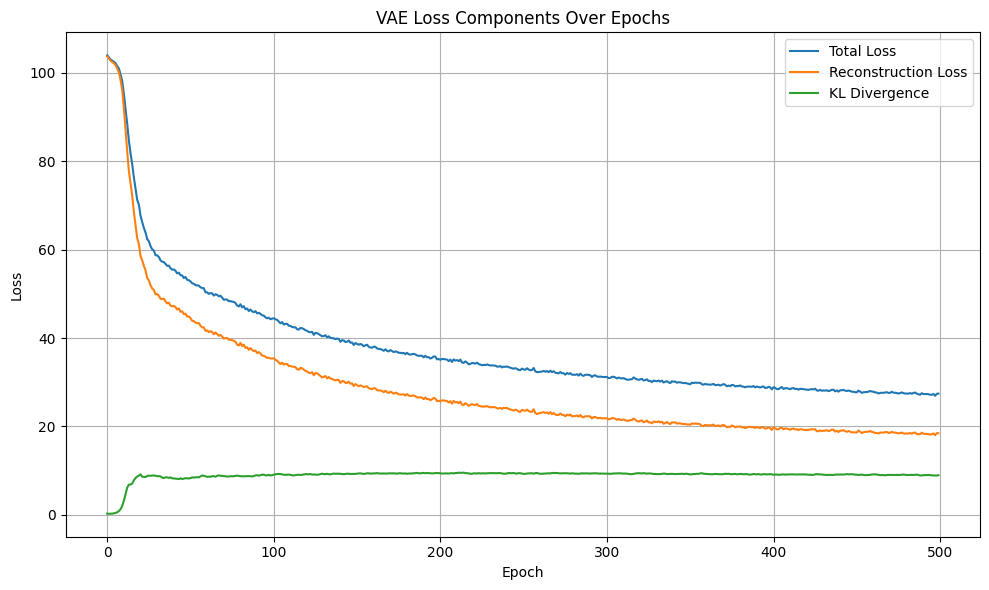

In [11]:
plot_vae_losses(total_loss_hist, recon_loss_hist, kld_loss_hist)

dim of latent mu: (331, 10)


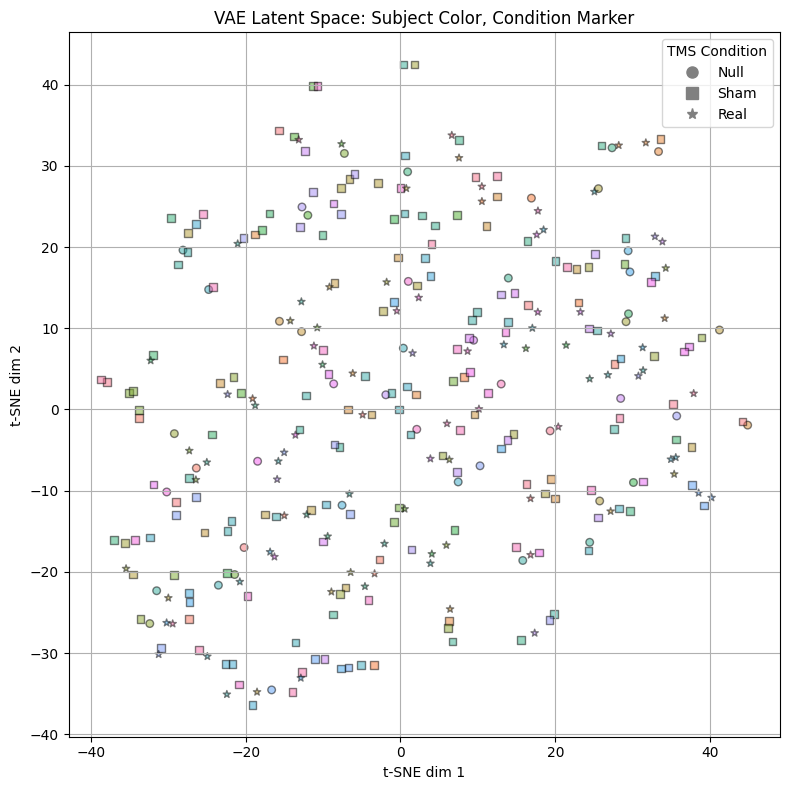

In [15]:
mu_all = get_latent_mu_cvae(model, X_tensor, subject_cond_tensor, device=DEVICE)
# 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)
plot_latent_embedding_by_condition_and_subject(z_2d, all_tms_type, all_subject_id)

Paired t-test: t = -2.449, p = 0.0183


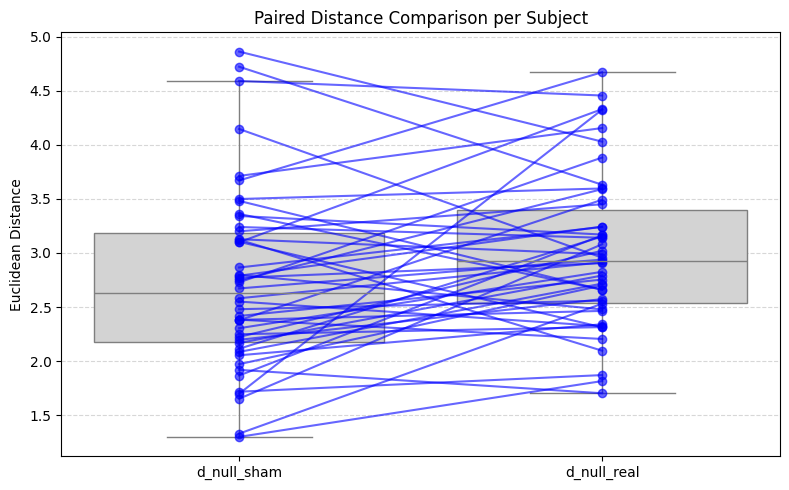

In [15]:
df = compute_condition_distances(mu_all, all_tms_type, all_subject_id, condition_map)

# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
plot_subject_distance_comparison(df)

In [16]:
output_filename = f"../../data_mri_processed/dist_summary_roi_{use_roi}.csv"

# Save DataFrame to CSV
df.to_csv(output_filename, index=False)

In [17]:
df_session_dists = compute_per_session_dist_to_null(mu_all, all_subject_id, all_tms_type, all_session)
df_session_dists.head(10)

output_filename = f"../../data_mri_processed/session_distances_roi_{use_roi}.csv"

# Save to CSV
df_session_dists.to_csv(output_filename, index=False)